## ConvLSTM Encoder and Decoder Architecture

In [12]:
import torch 
from training import ConvLSTM_GestureRecognitionModel
from colorVideoDataset import ColorVideoDataset
from datasetModule import GestureDataModule

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix

In [13]:
MODEL_PATH = 'ConvLstm_final.pth'      
DATA_ROOT_DIR = './colors'            
BATCH_SIZE = 16
NUM_CLASSES = 8 
MODEL_CHECKPOINT = "checkpoints\convlstm-epoch=99-val_loss=0.87.ckpt"

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Admin\AppData\Local\Temp\ipykernel_2532\515626610.py:5: SyntaxWarning: invalid escape sequence '\c'
  MODEL_CHECKPOINT = "checkpoints\convlstm-epoch=99-val_loss=0.87.ckpt"


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM_GestureRecognitionModel(num_classes=NUM_CLASSES).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval() # Set the model to evaluation mode
print("Model loaded successfully and set to evaluation mode.")

Model loaded successfully and set to evaluation mode.


In [15]:
dataset = ColorVideoDataset(root_dir=DATA_ROOT_DIR, transform=None)
class_names = dataset.get_class_names()
print(f"Dataset loaded with {len(dataset)} samples and {NUM_CLASSES} classes: {class_names}")

Dataset loaded with 320 samples and 8 classes: ['black', 'blue', 'brown', 'green', 'orange', 'red', 'white', 'yellow']


In [16]:
import torch
import numpy as np
from pytorch_lightning import Trainer
from training import ConvLSTM_GestureRecognitionModel
from datasetModule import GestureDataModule

def infer(checkpoint_path, data_dir, batch_size=16, num_classes=8, gpus=1):
    # 1. Initialize the data module
    data_module = GestureDataModule(data_dir=data_dir, batch_size=batch_size)
    data_module.setup("validate")

    # 2. Load the model from the checkpoint
    try:
        model = ConvLSTM_GestureRecognitionModel(num_classes=num_classes)
        state_dict = torch.load(checkpoint_path, map_location="cpu")
        model.load_state_dict(state_dict)

        print(f"✅ Model successfully loaded from '{checkpoint_path}'")
    except Exception as e:
        print(f"❌ Error loading model checkpoint: {e}")
        return None, None

    # 3. Put the model in evaluation mode and to device
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() and gpus > 0 else "cpu")
    model.to(device)

    val_loader = data_module.val_dataloader()

    all_preds, all_labels = [], []

    # 4. Run inference without gradient tracking
    with torch.no_grad():
        for batch_idx, (x, y, _) in enumerate(val_loader):
            # --- Ensure correct tensor shape ---
            if x.shape[-1] == 3:
                x = x.permute(0, 1, 4, 2, 3)  # (B, T, H, W, C) → (B, T, C, H, W)
            elif x.shape[2] != 3:
                x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W) → (B, T, C, H, W)

            x = x.to(device)
            y = y.to(device)

            outputs = model(x)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f"Inference batch {batch_idx}/{len(val_loader)} complete")

    print("✅ Inference complete.")
    return np.array(all_preds), np.array(all_labels)


In [17]:
y_pred, y_true = infer(MODEL_PATH, DATA_ROOT_DIR)

✅ Model successfully loaded from 'ConvLstm_final.pth'
Inference batch 0/4 complete
✅ Inference complete.


### Confusion Matrix

In [18]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=True, figsize=(8, 6), cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # Handle any NaNs if a class has 0 samples

    # Prepare labels
    if class_names is None:
        num_classes = len(np.unique(y_true))
        class_names = [f"Class {i}" for i in range(num_classes)]

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


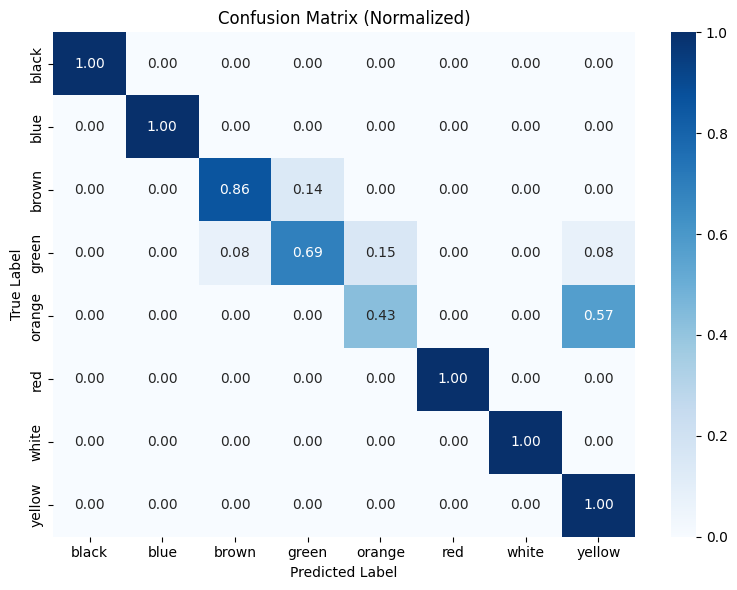

In [19]:
plot_confusion_matrix(y_true, y_pred, class_names=class_names, normalize=True)

### False Positives and False Negative's Matrix

In [ ]:
class_names = dataset.get_class_names()

In [ ]:
def calculate_ova_metrics(cm, class_names):
    metrics = {}
    # num_classes = len(class_names)
    
    for i, class_name in enumerate(class_names):
        TP = cm[i, i]
        
        FN = np.sum(cm[i, :]) - TP
        
        FP = np.sum(cm[:, i]) - TP
        
        TN = np.sum(cm) - (TP + FN + FP)
        
        metrics[class_name] = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}
        
    df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
    return df_metrics

In [ ]:
df_ova_metrics = calculate_ova_metrics(cm, class_names)

In [ ]:
def plot_ova_metrics(df_metrics, title='One-vs-All Performance Matrix'):
    plt.figure(figsize=(12, df_metrics.shape[0] * 1.5))
    
    sns.heatmap(df_metrics, 
                annot=True, 
                fmt='d',         
                cmap='YlGnBu',    
                linewidths=.5,    
                linecolor='black',
                cbar_kws={'label': 'Count'})
    
    plt.title(title, fontsize=16)
    plt.ylabel('Class (Treated as Positive)', fontsize=14)
    plt.xlabel('Metric', fontsize=14)
    plt.yticks(rotation=0)
    plt.show()

plot_ova_metrics(df_ova_metrics, title='OvA Classification Metrics (TP, TN, FP, FN)')

### F1, Recall, Precision Per Class